# Correction TP2: KNN, LDA, Logistic Regression

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import metrics
from sklearn import neighbors
from sklearn import datasets
from sklearn import metrics
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tp_knn_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d, ErrorCurve,
                           frontiere_new, LOOCurve)
import seaborn as sns
from matplotlib import rc

### Settings

In [2]:
# Plot
plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
# Seaborn
sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()
# Seed initialization
np.random.seed(seed=44)
# For saving files
saving_activated = True # False

### 1. Data Generation: Examples
From rand_gauss

In [3]:
n = 10
mu = [1., 1.]
sigma = [1., 1.]
rand_gauss(n, mu, sigma)

array([[ 0.24938528,  2.31635732],
       [ 2.24614003, -0.60491574],
       [-0.46814368, -0.71507046],
       [ 2.85878369,  1.08758798],
       [ 0.9476778 ,  1.55547164],
       [ 0.03659631,  0.81967853],
       [-0.18340916,  1.60544592],
       [ 0.04834945,  1.36085606],
       [ 2.06061026,  0.88284782],
       [ 1.82566485, -0.20981355]])

From rand_bi_gauss

In [4]:
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

From rand_tri_gauss

In [5]:
n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

From rand_clown

In [6]:
n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
X3, y3 = rand_clown(n1, n2, sigma1, sigma2)

From rand_checkers

In [7]:
n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = rand_checkers(n1, n2, sigma)

### 2. Displaying labeled data

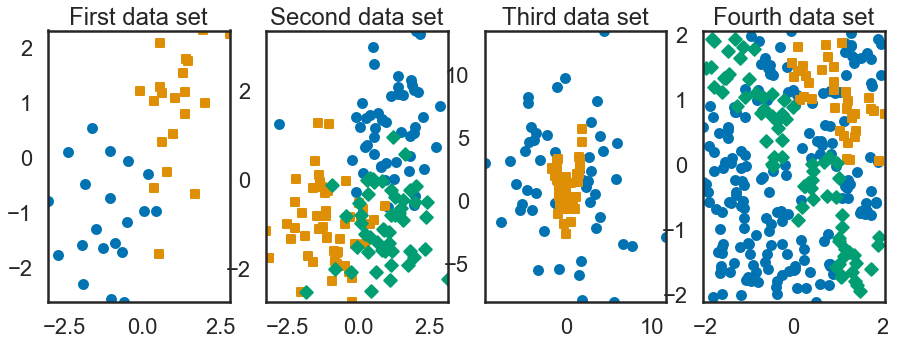

In [8]:
plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.subplot(141)
plt.title('First data set')
plot_2d(X1, y1)
plt.subplot(142)
plt.title('Second data set')
plot_2d(X2, y2)
plt.subplot(143)
plt.title('Third data set')
plot_2d(X3, y3)
plt.subplot(144)
plt.title('Fourth data set')
plot_2d(X4, y4)

## kNN

### 4. Write your own implementation of the kNN classifier

In [9]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Home made KNN Classifier class"""
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Save the data
        self.X_ = X
        self.y_ = y
        # Compute data portions
        self.labs_, self.labFreqs_ = np.unique(y, return_counts=True)
        self.ny_ = len(self.labs_)
        self.labFreqs_ = self.labFreqs_ / len(y)
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        # Compute all pairwise distances between X and self.X_
        dist = metrics.pairwise.pairwise_distances(
            X, Y=self.X_, metric='euclidean', n_jobs=1)
        # Get indices to sort them
        idx_sort = np.argsort(dist, axis=1)
        # Get indices of neighbors
        idx_neighbors = idx_sort[:, :self.n_neighbors]
        # Get labels of neighbors
        Y_neighbors = self.y_[idx_neighbors]
        # Find the predicted labels y for each entry in X
        y_pred = np.asarray([])
        for i in range(n_samples):
            cnt = Counter(Y_neighbors[i,:]).most_common()
            if len(cnt) == 1 or cnt[0][1] > cnt[1][1]:
                # If prediction is unique, just return it
                y_pred = np.append(y_pred, [cnt[0][0]])
            else:
                # If prediction is nonunique,
                elems = np.asarray([cnt[0][0]])
                # collect most frequent elements
                for i in range(1, len(cnt)):
                    if (cnt[i][1] == elems[0]):
                        elems = np.append(elems, cnt[i][0])
                        print(cnt[i][0])
                        print(elems)
                    else:
                        break
                elems.sort()
                # Draw one of them at random with prior frequencies
                probs = self.labFreqs_[np.where(np.isin(self.labs_, elems))]
                probs = probs / sum(probs)
                iRand = np.random.choice(range(len(elems)), size=1, p=probs)
                y_pred = np.append(y_pred, elems[iRand])
        # Three li
        #mode, _ = stats.mode(Y_neighbors, axis=1)
        #print(mode)
        #y_pred = np.asarray(mode.ravel(), dtype=np.intp)
        return y_pred

Compare your implementation with scikit-learn

In [10]:
# Focus on dataset 2
X_train = X2[::2]
Y_train = y2[::2].astype(int)
X_test = X2[1::2]
Y_test = y2[1::2].astype(int)
# Using you own implementation
n_neighbors = 5
# n_neighbors = 2 # different on this case because of ties
knn = KNNClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
# Using scikit-learn
sknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
sknn.fit(X_train, Y_train)
Y_pred_skl = sknn.predict(X_test)
# Check
assert np.all(Y_pred == Y_pred_skl) # other choice possible: with np.allclose

In [11]:
plt.ion()

### 5. Test now all datasets

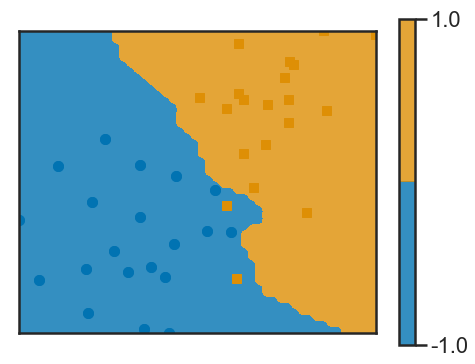

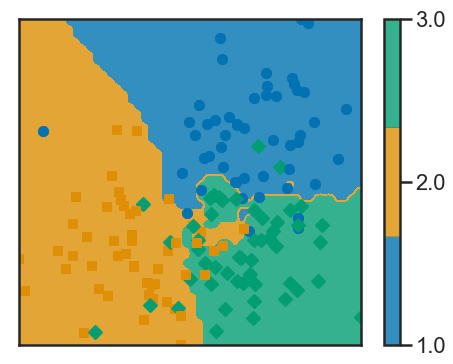

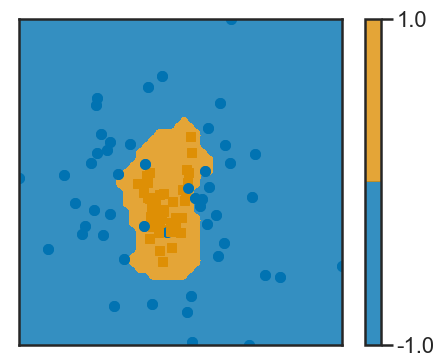

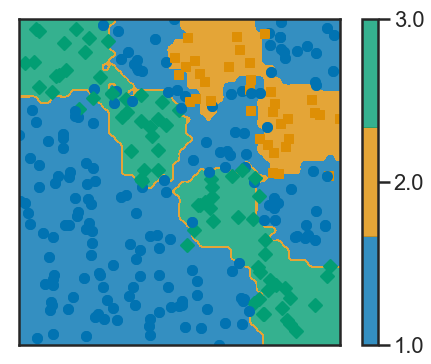

In [12]:
n_neighbors = 5 # the k in kNN
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# for data in [data1, data2, data3, data4]:
for X, y in [(X1, y1), (X2, y2), (X3, y3), (X4, y4)]:
    def f(xx):
        """Classifier: needed to avoid warning due to shape issues"""
        return knn.predict(xx.reshape(1, -1))
    knn.fit(X, y)
    plt.figure()
    plot_2d(X, y)
    frontiere_new(f, X, y, w=None, step=50, alpha_choice=1)

### 6. Display the result when varying the value of k

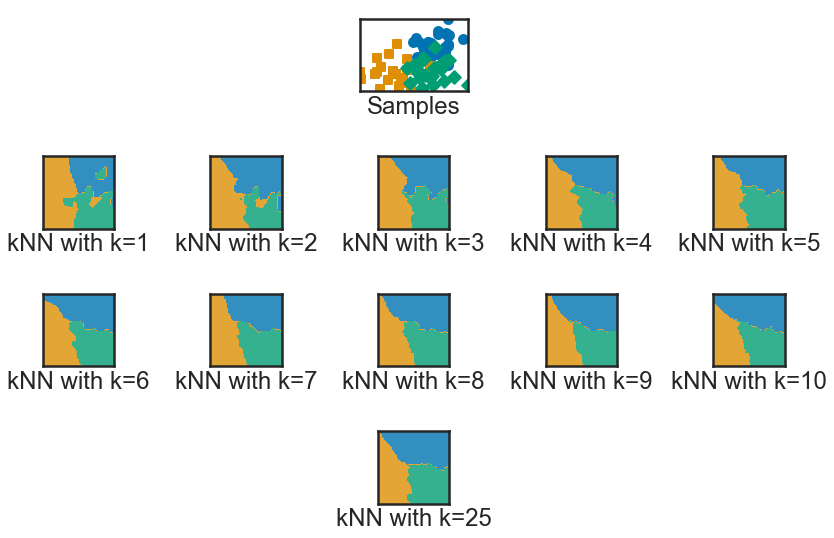

In [13]:
X_train = X2[::2]
Y_train = y2[::2].astype(int)
plt.figure(3, figsize=(12, 8))
plt.subplot(4, 5, 3)
plot_2d(X_train, Y_train)
plt.xlabel('Samples')
ax = plt.gca()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
# Plot iteratively
for n_neighbors in list(range(1, 11)) + [int(X_train.shape[0] / 3)]:
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, Y_train)
    if n_neighbors > 11:
        plt.subplot(4, 5, 18)
    else:
        plt.subplot(4, 5, 5 + n_neighbors)
    plt.xlabel('kNN with k=%d' % n_neighbors)

    def f(xx):
        """Classifier: needed to avoid warning due to shape issues"""
        return knn.predict(xx.reshape(1, -1))
    frontiere_new(f, X, y, w=None, step=50, alpha_choice=1,
                  colorbar=False, samples=False)
    plt.draw() # update plot
plt.tight_layout()

### 7. Weighted kNN

In [14]:
def weights(dist):
    """Returns an array of weights, exponentially decreasing in the square
    of the distance.

    Parameters
    ----------
    dist : a one-dimensional array of distances.

    Returns
    -------
    weight : array of the same size as dist
    """
    return np.exp(-dist ** 2 / 0.1)

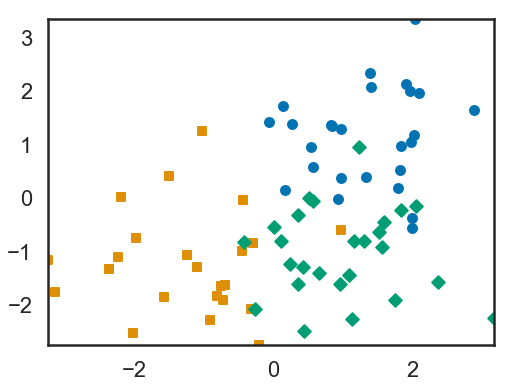

In [15]:
X_train = X2[::2]
Y_train = y2[::2].astype(int)
n_neighbors = 5
wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
wknn.fit(X_train, Y_train)
plt.figure(4)
plot_2d(X_train, Y_train)

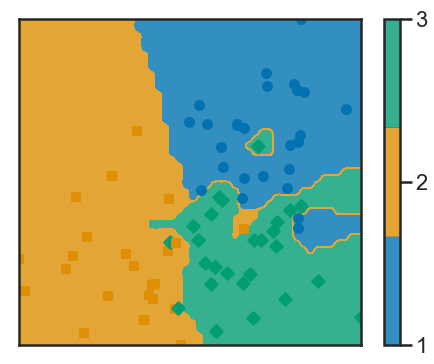

In [16]:
def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return wknn.predict(xx.reshape(1, -1))
frontiere_new(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

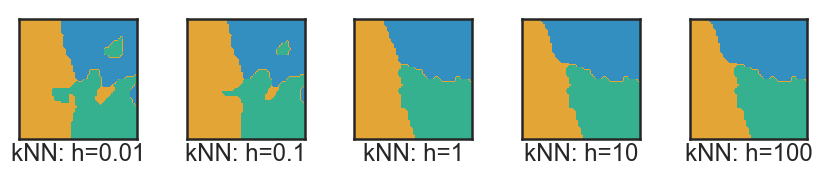

In [17]:
X_train = X2[::2]
Y_train = y2[::2].astype(int)
plt.figure(5, figsize=(12, 8))
n_neighbors = 7
for hExp in range(-2, 3):
    def weights_opt(dist):
        return np.exp(-dist ** 2 / (10 ** hExp))
    wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights_opt)
    wknn.fit(X_train, Y_train)
    plt.subplot(1, 5, hExp + 3)
    plt.xlabel('kNN: h={}'.format(10 ** hExp))
    def f(xx):
        """Classifier: needed to avoid warning due to shape issues"""
        return wknn.predict(xx.reshape(1, -1))
    frontiere_new(f, X, y, w=None, step=50, alpha_choice=1,
                  colorbar=False, samples=False)
    plt.draw() # update plot
plt.tight_layout()

### 8. Scores on train data

In [18]:
n_neighbors = 1
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)
# Output the error rates
print(knn.score(X_train, Y_train))
print(knn.score(X_test, Y_test))

1.0
0.7066666666666667


### 9. Scores on left out data

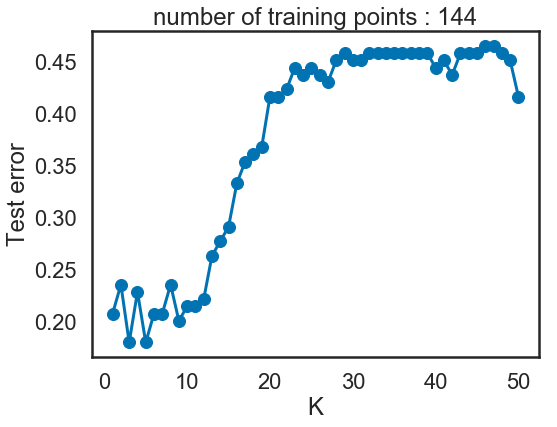

In [19]:
# Choose the data
X_train = X4[::2]
Y_train = y4[::2].astype(int)
X_test = X4[1::2]
Y_test = y4[1::2].astype(int)
# Prepare the plot
error_curve = ErrorCurve(k_range=range(1, 51))
error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
plt.figure(5)
error_curve.plot()

### 10. Error curves for different sizes

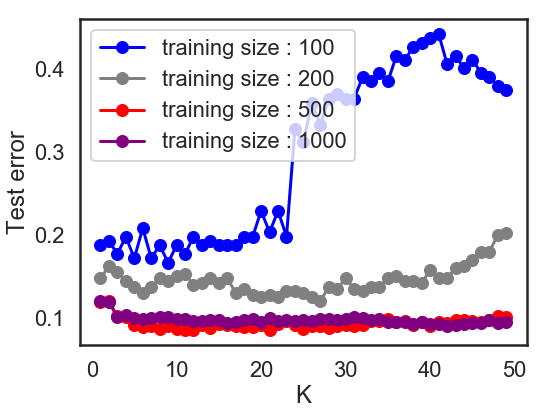

In [20]:
sigma = 0.1
plt.figure(5)
range_n_samples = [100, 200, 500, 1000]
niter = len(range_n_samples)
error_curve = ErrorCurve(k_range=range(1, 50, 1))
collist = ['blue', 'grey', 'red', 'purple', 'orange', 'salmon', 'black',
           'fuchsia']
for n in range(niter):
    n1 = n2 = range_n_samples[n]
    X_train, Y_train = rand_checkers(n1, n2, sigma)
    X_test, Y_test = rand_checkers(n1, n2, sigma)
    error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
    error_curve.plot(color=collist[n % len(collist)], maketitle=False)
plt.legend(["training size : %d" % n for n in range_n_samples],
           loc='upper left')

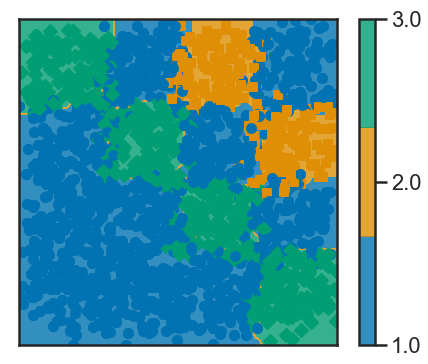

In [21]:
plt.figure(6)
plot_2d(X_train, Y_train)
n_neighbors = 40
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)
def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return knn.predict(xx.reshape(1, -1))
frontiere_new(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

### 12. Digits data: test kNN on DIGITS dataset

Presentation of the DIGITS dataset

In [22]:
# The digits dataset
digits = datasets.load_digits()
print(type(digits))
# A Bunch is a subclass of 'dict' (dictionary)
# help(dict)
# see also "http://docs.python.org/2/library/stdtypes.html#mapping-types-dict"
print(digits.keys())
print(digits.target[:50])
print(len(digits.data))
print(digits.data[0])
print(digits['data'][0])
print(digits['images'][0])
print(digits.data[0] == digits['data'][0])

<class 'sklearn.utils.Bunch'>
dict_keys(['images', 'target_names', 'data', 'target', 'DESCR'])
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]
1797
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0. 

Plot DIGITS' images

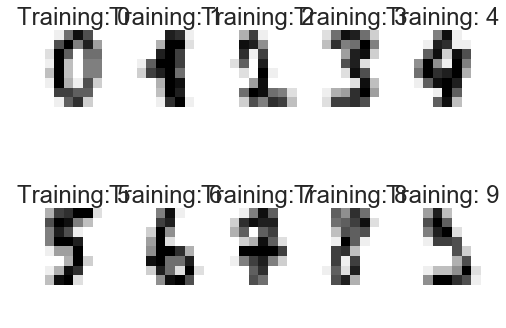

In [23]:
plt.figure(7)
for idx, (img, lbl) in enumerate(list(zip(digits.images,
                                          digits.target))[10:20]):
    plt.subplot(2, 5, idx + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: %i' % lbl)

Plot histogram

(array([88., 91., 86., 91., 92., 91., 91., 89., 88., 92.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

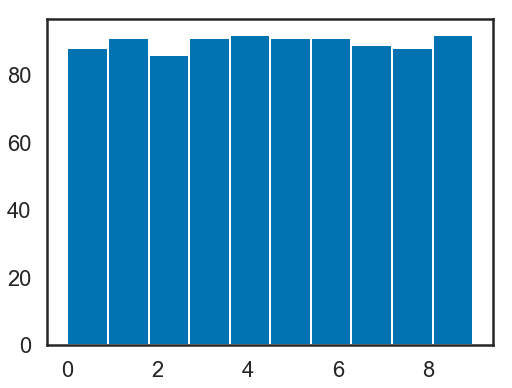

In [24]:
n_samples = len(digits.data)
X_train = digits.data[:n_samples // 2]
Y_train = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]
plt.figure(8)
plt.hist(Y_test)

Test kNN

In [25]:
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, Y_train)
score = knn.score(X_test, Y_test)
Y_pred = knn.predict(X_test)
print(score)
#(Y_test == Y_pred).mean()

0.9254727474972191


### 13. Compute confusion matrix

[[87  0  0  0  1  0  0  0  0  0]
 [ 0 82  5  1  0  1  0  0  0  2]
 [ 1  0 79  6  0  0  0  0  0  0]
 [ 0  0  0 81  0  3  0  4  1  2]
 [ 2  0  0  0 87  0  0  2  1  0]
 [ 0  0  0  0  0 85  3  0  0  3]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  1  0  0  0  0 88  0  0]
 [ 0  6  1  6  0  4  1  1 68  1]
 [ 1  0  0  4  0  2  0  0  1 84]]
[[0.98863636 0.         0.         0.         0.01136364 0.
  0.         0.         0.         0.        ]
 [0.         0.9010989  0.05494505 0.01098901 0.         0.01098901
  0.         0.         0.         0.02197802]
 [0.01162791 0.         0.91860465 0.06976744 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.89010989 0.         0.03296703
  0.         0.04395604 0.01098901 0.02197802]
 [0.02173913 0.         0.         0.         0.94565217 0.
  0.         0.02173913 0.01086957 0.        ]
 [0.         0.         0.         0.         0.         0.93406593
  0.03296703 0.         0.         0.03296703]
 [0

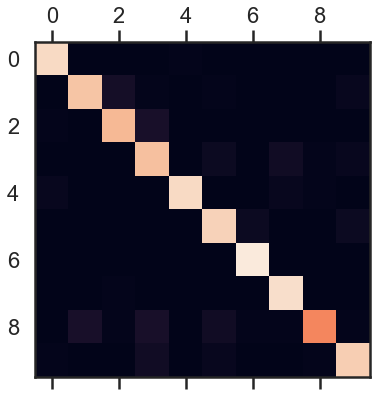

In [26]:
CM = metrics.confusion_matrix(Y_test, Y_pred)
print(CM)
CM_norm = 1.0 * CM / CM.sum(axis=1)[:, np.newaxis]
print(CM_norm)
plt.matshow(CM)

### 14. Estimate k with cross-validation

[0.995 0.995 0.98  0.98  0.985 0.975 0.965 0.96  0.965 0.96  0.93  0.915]


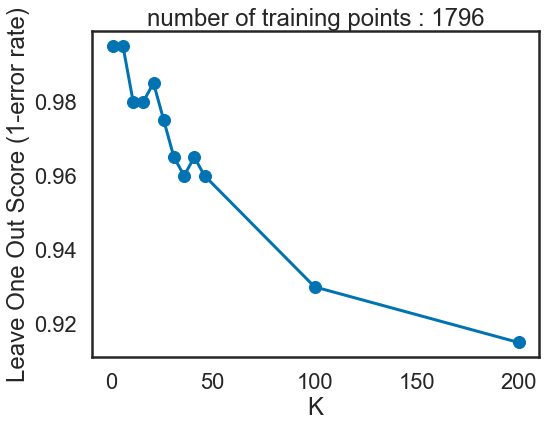

In [27]:
# Have a look at the class 'LOOCurve', defined in the source file.
loo_curve = LOOCurve(k_range=list(range(1, 50, 5)) + list(range(100, 300, 100)))
loo_curve.fit_curve(X=digits.data, y=digits.target)
print(loo_curve.cv_scores)
plt.figure(9)
loo_curve.plot()

## LDA

### 18. Write your own implementation of the LDA classifier

In [28]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    """ Home made LDA Classifier class"""
    def fit(self, X, y):
        n_, d_ = X.shape
        X_ = X[y.argsort(),:]
        y_ = np.sort(y)
        counts_ = np.unique(y, return_counts=True)
        iSecond_ = counts_[1][0] # start of second class
        mNeg_ = np.mean(X_[range(0,iSecond_),:], axis=0)
        mPos_ = np.mean(X_[range(iSecond_,n_),:], axis=0)
        cov_ = (np.cov(X_[range(0,iSecond_),:].T) * (iSecond_ - 1) + np.cov(X_[range(iSecond_,n_),:].T) * (n_ - iSecond_ - 1)) / (n_ - 2)
        # Calculate multipliers
        self.preMul1_ = np.linalg.inv(cov_)@(mPos_ - mNeg_)
        self.preMul2_ = 0.5*mPos_.T@np.linalg.inv(cov_)@mPos_ - 0.5*mNeg_.T@np.linalg.inv(cov_)@mNeg_ + np.log(iSecond_ / n_) - np.log(1. - iSecond_ / n_)
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        return (np.round(X@self.preMul1_ > self.preMul2_)*2 - 1).astype(int)

### 19. Check its performance and compare with scikit-learn

The result coincides in 132000 cases out of 132000.
Factory error rate: 11.22%.
Homemade error rate: 11.22%.


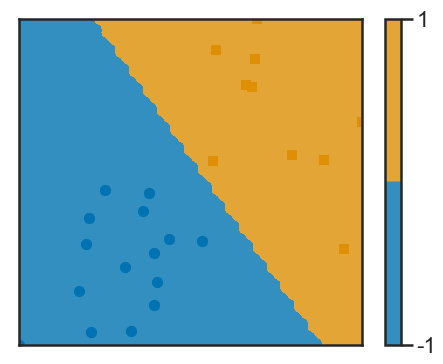

In [29]:
# Generate additional train and test data
X5,y5 = rand_bi_gauss(10, 15, [1,1], [-1,-1], [0.9, 0.9], [0.9, 0.9])
X_train = X5
Y_train = y5
X5,y5 = rand_bi_gauss(120000, 12000, [1,1], [-1,-1], [0.9, 0.9], [0.9, 0.9])
X_test = X5
Y_test = y5
# Check the performance and compare with the scikit-learn implementation
clfMy = LDAClassifier()
clfMy.fit(X_train, Y_train)
y_predMy = clfMy.predict(X_test)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
print('The result coincides in {} cases out of {}.'.format((y_predMy == y_pred).sum(), Y_test.shape[0]))
print('Factory error rate: {:2.2%}.'.format((y_pred != Y_test).mean()))
print('Homemade error rate: {:2.2%}.'.format((y_predMy != Y_test).mean()))
# Visualise the separation rule
def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clfMy.predict(xx.reshape(1, -1))
plt.figure(10)
plot_2d(X_train, Y_train)
frontiere_new(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

### 20. Plot separation rules for two different cases

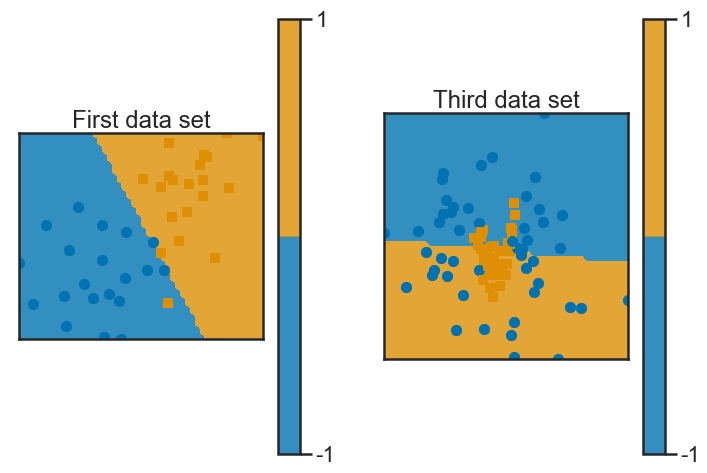

In [30]:
clfMy = LDAClassifier()
plt.figure(11, figsize=(12, 8))
def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clfMy.predict(xx.reshape(1, -1))
plt.subplot(1, 2, 1)
plt.title('First data set')
plot_2d(X1, y1)
clfMy.fit(X1, y1)
frontiere_new(f, X1, y1, w=None, step=50, alpha_choice=1)
plt.subplot(1, 2, 2)
plt.title('Third data set')
plot_2d(X3, y3)
clfMy.fit(X3, y3)
frontiere_new(f, X3, y3, w=None, step=50, alpha_choice=1)

## Logistic regression

### 21. Apply to disequlibrated data

In [31]:
n1 = 50
n2 = 6
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.2, 0.9]
sigma2 = [0.8, 0.6]
X6, y6 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)
# Regression Logistique sur ces donnees
clf = linear_model.LogisticRegression(solver='lbfgs')
clf.fit(X6, y6)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### 23. Plot the separation rule

coeff :  [[1.71812481 1.11080097]]
intercept :  [1.77220873]


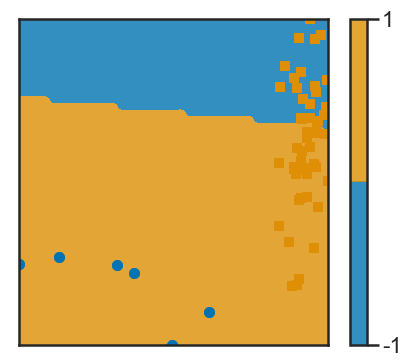

In [32]:
print('coeff : ', clf.coef_)
print('intercept : ', clf.intercept_)
plt.figure(12)
plot_2d(X6, y6)
frontiere_new(f, X6, y6, w=None, step=50, alpha_choice=1)

### 24. Apply to the DIGITS data

In [33]:
# The digits dataset
digits = datasets.load_digits()
# Split into training and testing
X_train = digits.data[:n_samples // 2]
Y_train = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]
# Fit linear regression
logreg = linear_model.LogisticRegression(solver='liblinear', multi_class='ovr')
logreg.fit(X_train, Y_train)
# Calculate the score
score = logreg.score(X_test, Y_test)
Y_pred = logreg.predict(X_test)
print(np.mean(Y_pred == Y_test), score)

0.9165739710789766 0.9165739710789766
